In [ ]:
! pip install -q kaggle
! pip install h5py

In [ ]:
!kaggle datasets download -d sadmansakibmahi/plant-disease-expert

Dataset URL: https://www.kaggle.com/datasets/sadmansakibmahi/plant-disease-expert
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 6.54G/6.54G [01:40<00:00, 99.7MB/s]
100% 6.54G/6.54G [01:40<00:00, 69.7MB/s]


In [ ]:
!unzip /content/plant-disease-expert.zip

Streaming output truncated to the last 5000 lines.
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy3715.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy3716.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy3717.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy3718.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy3719.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy372.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy3720.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy3721.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy3722.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy3723.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy3724.jpg  
  inflating: Im

In [ ]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import time
import shutil

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
tf.get_logger().setLevel('ERROR')

In [ ]:
image_data_base_folder = r'/content/Image Data base/Image Data base'

# Path to the dataformodel folder
dataformodel_folder = '/content/dataformodel'

# Get the list of folders inside the Image Data base folder
folders = os.listdir(image_data_base_folder)

# Create a folder inside the dataformodel folder for each folder in the Image Data base folder
for folder in folders:
    folder_path = os.path.join(dataformodel_folder, folder)
    os.makedirs(folder_path, exist_ok=True)

In [ ]:
# Get the list of folders inside the Image Data base folder
folders = os.listdir(image_data_base_folder)

# Copy at most 75 images from each folder to the corresponding folder in the dataformodel folder
for folder in folders:
    source_folder = os.path.join(image_data_base_folder, folder)
    destination_folder = os.path.join(dataformodel_folder, folder)

    # Create the destination folder if it doesn't exist
    os.makedirs(destination_folder, exist_ok=True)

    # Get the list of image files in the source folder
    image_files = [file for file in os.listdir(source_folder) if file.endswith('.jpg') or file.endswith('.png')]

    # Delete existing files in the destination folder
    existing_files = [file for file in os.listdir(destination_folder) if file.endswith('.jpg') or file.endswith('.png')]
    for existing_file in existing_files:
        os.remove(os.path.join(destination_folder, existing_file))

    # Copy at most 75 images from the source folder to the destination folder
    for i in range(min(120, len(image_files))):
        source_file = os.path.join(source_folder, image_files[i])
        destination_file = os.path.join(destination_folder, image_files[i])
        shutil.copyfile(source_file, destination_file)

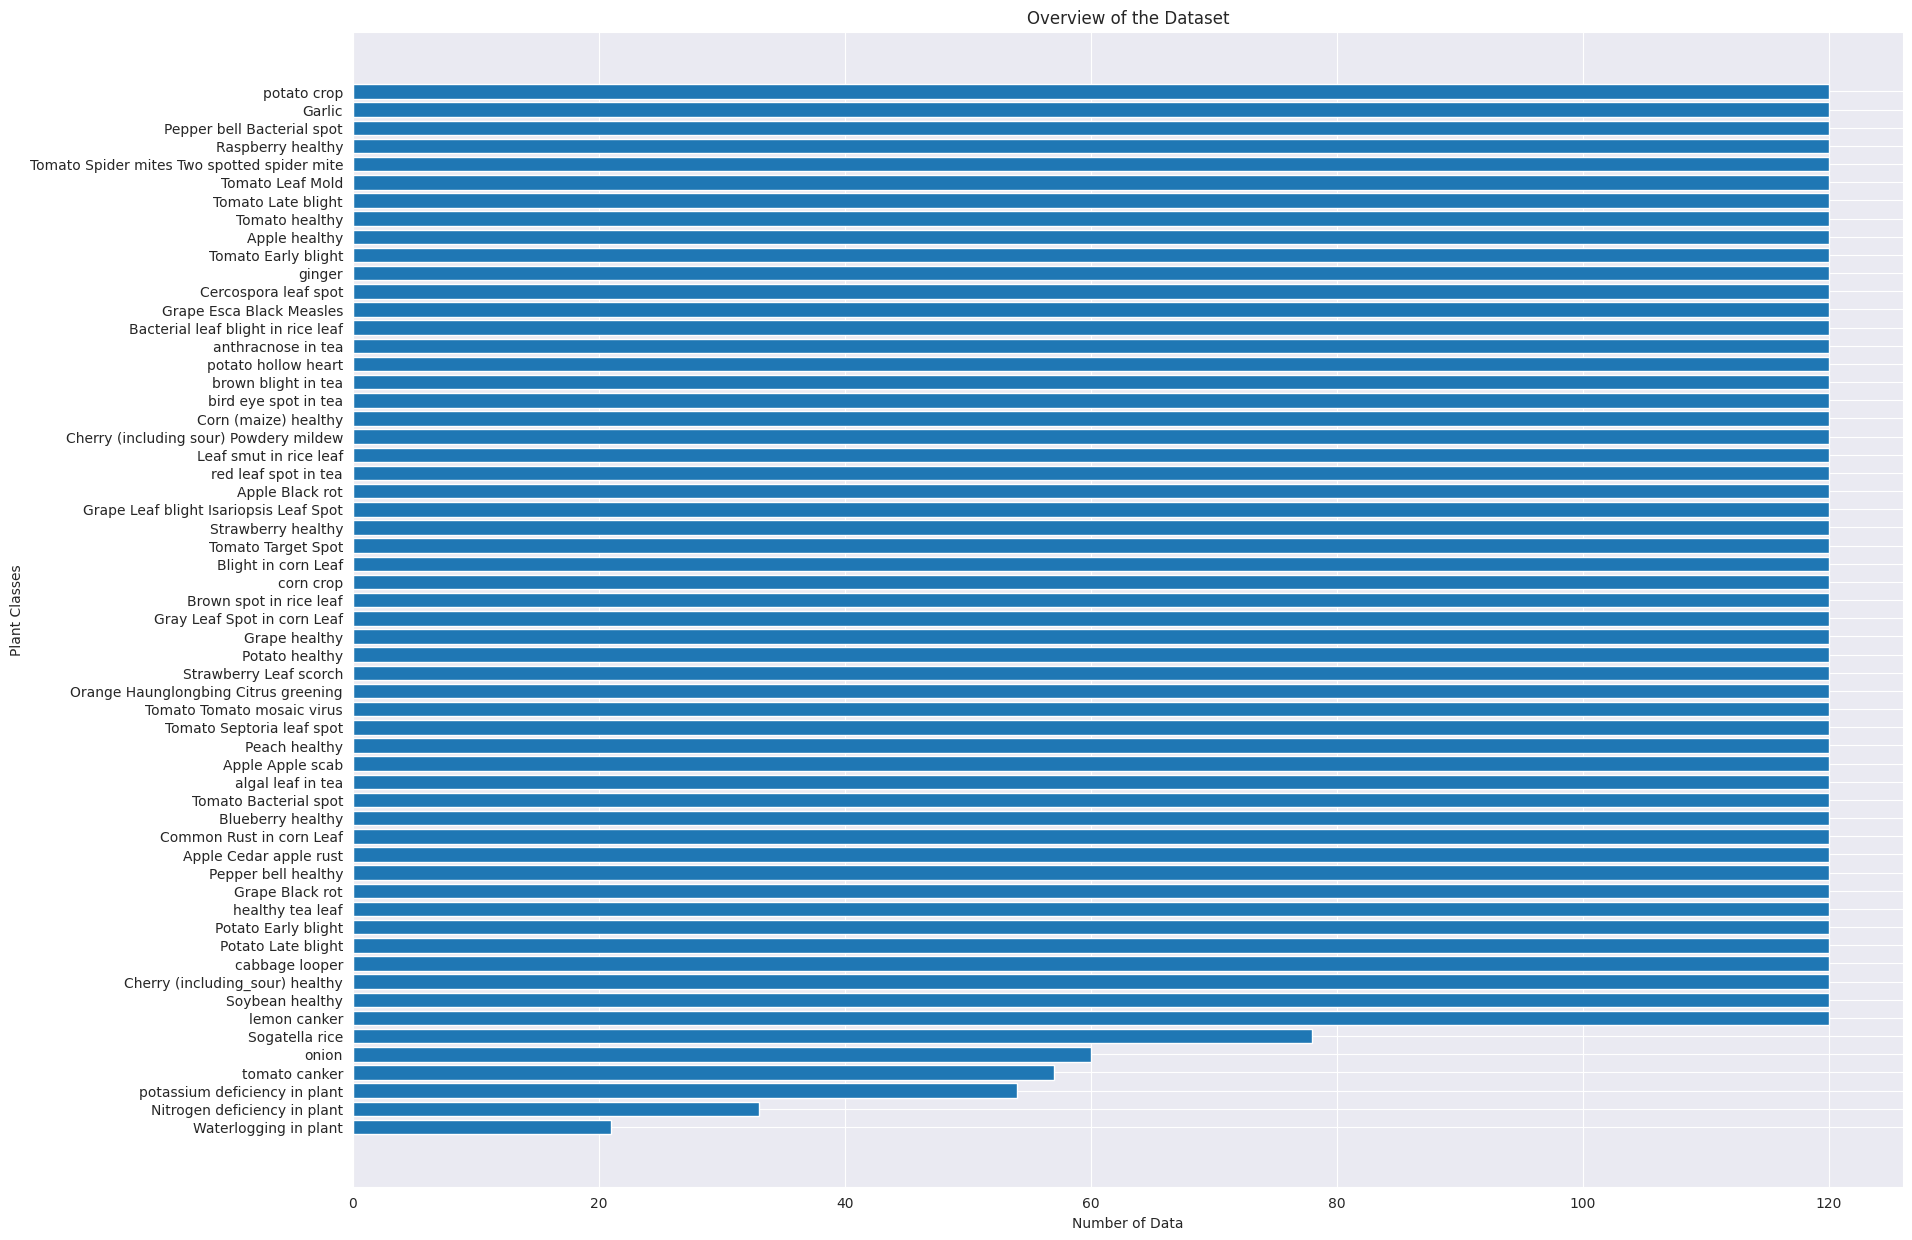

//////////////////////////////
                      Plant Class  Number of Images
52          Waterlogging in plant                21
33   Nitrogen deficiency in plant                33
23  potassium deficiency in plant                54
41                  tomato canker                57
6                           onion                60
//////////////////////////////
class  Nitrogen deficiency in plant  has only 33  samples and will not be included in dataframe
class  Waterlogging in plant  has only 21  samples and will not be included in dataframe
train_df lenght:  5840   test_df length:  325   valid_df length:  324
The number of classes in the dataset is:  56
            CLASS               IMAGE COUNT 
       Apple Apple scab             108     
       Apple Black rot              108     
    Apple Cedar apple rust          108     
        Apple healthy               108     
Bacterial leaf blight in rice leaf      108     
     Blight in corn Leaf            108     
      B

In [ ]:
directory = '/content/dataformodel'

total_number = 0
total_classes = 0
name_classes = []
len_classes = []

for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder)
    if os.path.isdir(folder_path):
        num_files = len(os.listdir(folder_path))
        len_classes.append(num_files)
        name_classes.append(folder)
        total_number += num_files
        total_classes += 1

data = {'Plant Class': name_classes, 'Number of Images': len_classes}

df = pd.DataFrame(data)
df_sorted = df.sort_values('Number of Images')

plt.figure(figsize=(20, 15))
plt.barh(df_sorted['Plant Class'], df_sorted['Number of Images'])
plt.title('Overview of the Dataset')
plt.xlabel('Number of Data')
plt.ylabel('Plant Classes')
plt.show()
print("//////////////////////////////")
min_classes = df_sorted.head(5)
print(min_classes[['Plant Class', 'Number of Images']])



print("//////////////////////////////")

sdir=(directory)
min_samples=40 # set limit for minimum images a class must have to be included in the dataframe
filepaths = []
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir, klass)
    flist=os.listdir(classpath)
    if len(flist) >= min_samples:
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    else:
        print('class ', klass, ' has only', len(flist), ' samples and will not be included in dataframe')
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
train_df, dummy_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

In [ ]:
batch_size=20 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=(200, 250),
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size= (200, 250),
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size= (200, 250),
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)


print("Total Train Image:-",len(train_df))
print("Total Validation Image:-",len(valid_df))
print("Total Test Image:-",len(test_df))

Found 5840 validated image filenames belonging to 56 classes.
Found 324 validated image filenames belonging to 56 classes.
Found 325 validated image filenames belonging to 56 classes.
test batch size:  65   test steps:  5  number of classes :  56
Total Train Image:- 5840
Total Validation Image:- 324
Total Test Image:- 325


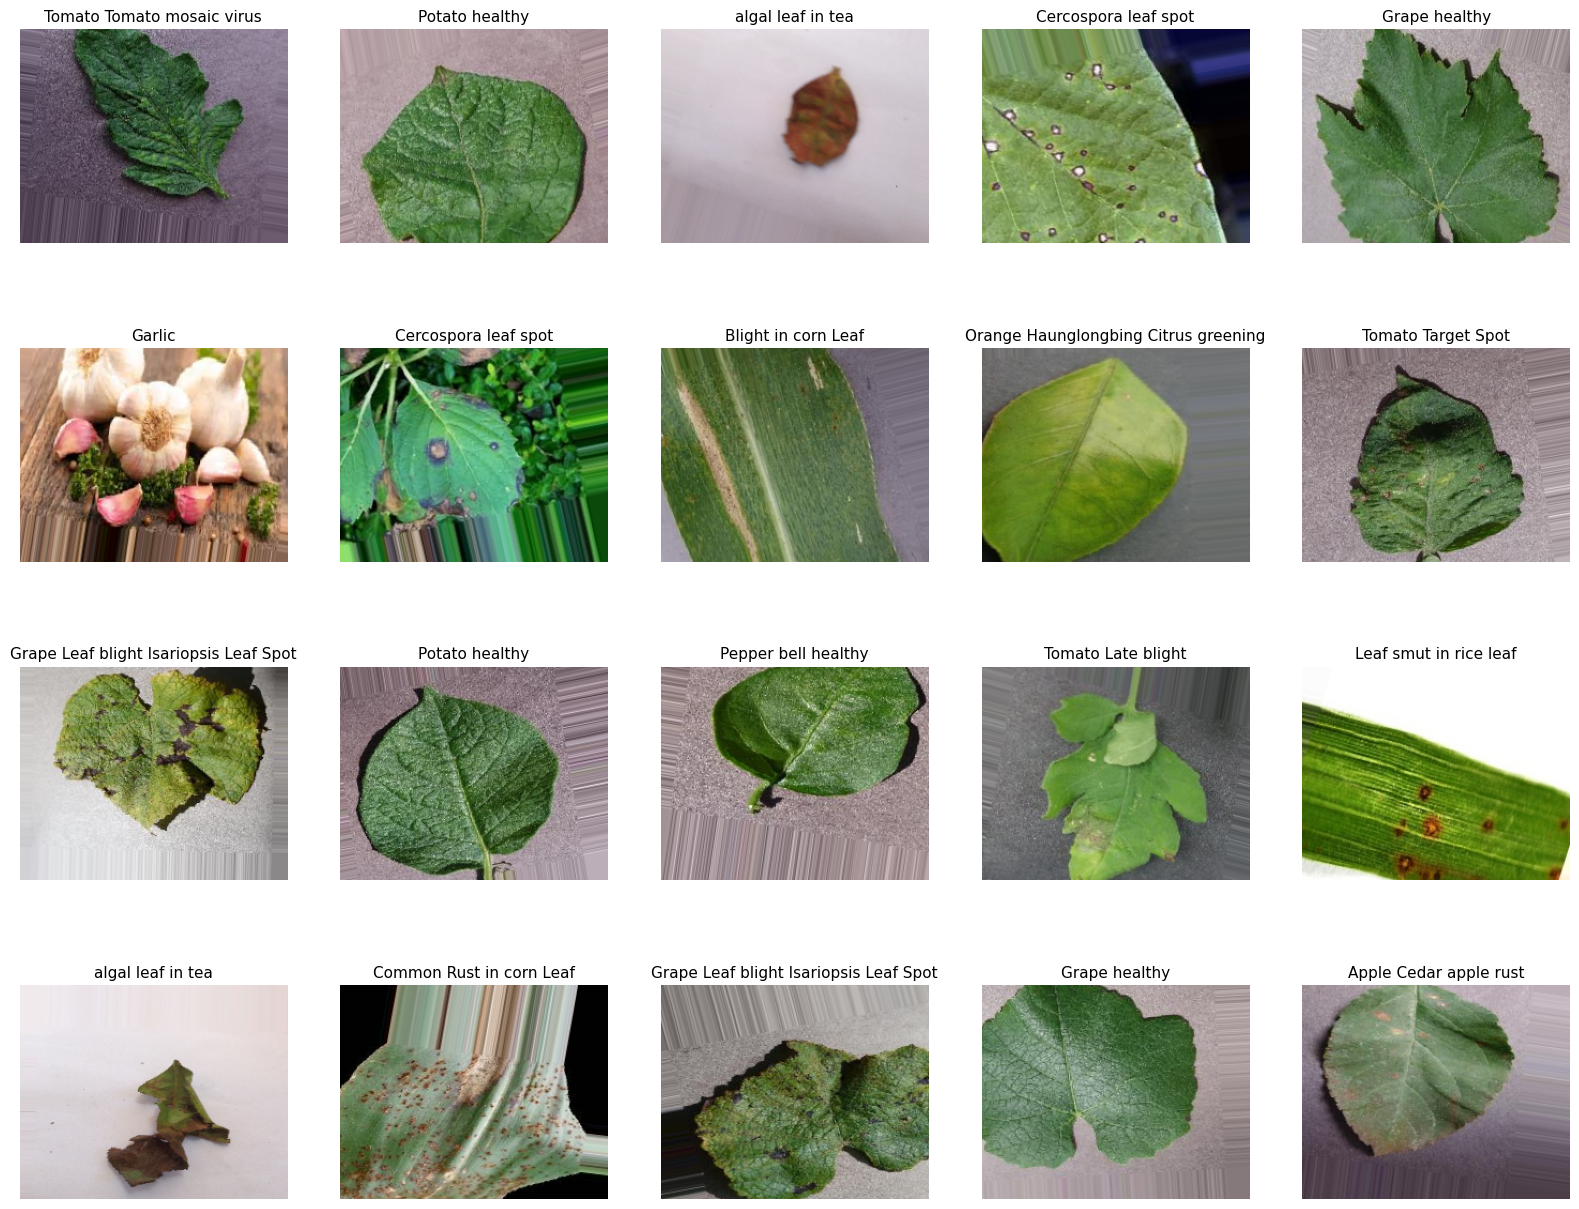

In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='black', fontsize=11)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen)

In [ ]:
! pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.7 MB/s eta 0:00:00


In [ ]:
from efficientnet.tfkeras import EfficientNetB3  # Import EfficientNetB3

# Assuming df contains the file paths and labels
# Adjust the input shape based on the requirements of EfficientNetB3
input_shape = (300, 300, 3)

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])

# Create an instance of the EfficientNetB3 model pre-trained on ImageNet data
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Build your model on top of the EfficientNetB3 base
num_classes = len(train_df['labels'].unique())
model = keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Create data generators
batch_size = 32
trgen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2)
tgen = ImageDataGenerator(rescale=1./255)

train_gen = trgen.flow_from_dataframe(dataframe=train_df, directory=None,
                                      x_col='filepaths', y_col='labels',
                                      target_size=(input_shape[0], input_shape[1]),
                                      class_mode='categorical',
                                      batch_size=batch_size)

test_gen = tgen.flow_from_dataframe(dataframe=test_df, directory=None,
                                    x_col='filepaths', y_col='labels',
                                    target_size=(input_shape[0], input_shape[1]),
                                    class_mode='categorical',
                                    batch_size=batch_size,
                                    shuffle=False)

Found 5191 validated image filenames belonging to 56 classes.
Found 1298 validated image filenames belonging to 56 classes.


In [ ]:
epochs = 30

history = model.fit(train_gen,
                    epochs=epochs,
                    validation_data=test_gen
                    )

Epoch 1/30
163/163 [==============================] - 221s 1s/step - loss: 2.4064 - accuracy: 0.3714 - val_loss: 1.0902 - val_accuracy: 0.7573
Epoch 2/30
163/163 [==============================] - 176s 1s/step - loss: 1.2240 - accuracy: 0.6378 - val_loss: 0.7182 - val_accuracy: 0.7974
Epoch 3/30
163/163 [==============================] - 176s 1s/step - loss: 0.9306 - accuracy: 0.7145 - val_loss: 0.5917 - val_accuracy: 0.8159
Epoch 4/30
163/163 [==============================] - 182s 1s/step - loss: 0.7947 - accuracy: 0.7451 - val_loss: 0.4954 - val_accuracy: 0.8421
Epoch 5/30
163/163 [==============================] - 174s 1s/step - loss: 0.6793 - accuracy: 0.7871 - val_loss: 0.4501 - val_accuracy: 0.8659
Epoch 6/30
163/163 [==============================] - 182s 1s/step - loss: 0.6353 - accuracy: 0.7956 - val_loss: 0.3897 - val_accuracy: 0.8798
Epoch 7/30
163/163 [==============================] - 180s 1s/step - loss: 0.5821 - accuracy: 0.8097 - val_loss: 0.3766 - val_accuracy: 0.8790

41/41 [==============================] - 21s 372ms/step


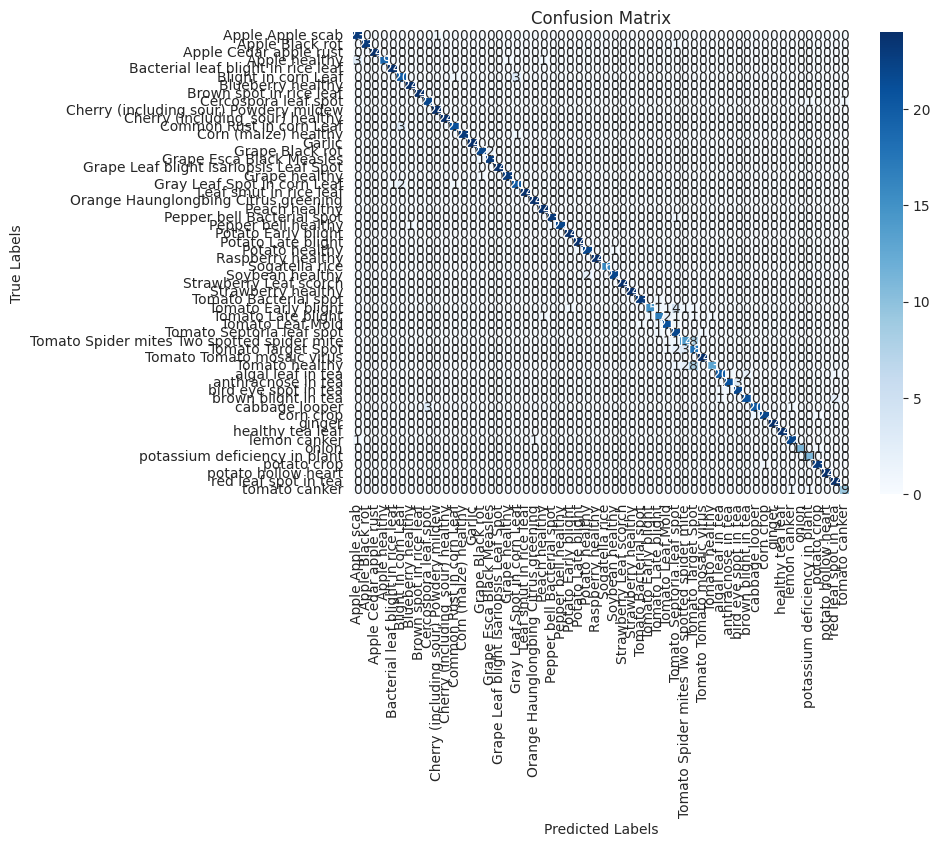

Classification Report:
                                              precision    recall  f1-score   support

                           Apple Apple scab       0.85      0.96      0.90        24
                            Apple Black rot       1.00      0.96      0.98        24
                     Apple Cedar apple rust       1.00      1.00      1.00        24
                              Apple healthy       1.00      0.79      0.88        24
         Bacterial leaf blight in rice leaf       0.96      1.00      0.98        24
                        Blight in corn Leaf       0.80      0.83      0.82        24
                          Blueberry healthy       0.96      1.00      0.98        24
                    Brown spot in rice leaf       1.00      1.00      1.00        24
                       Cercospora leaf spot       0.88      0.92      0.90        24
     Cherry (including sour) Powdery mildew       0.96      1.00      0.98        24
            Cherry (including_sour) heal

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Make predictions on the test set
y_pred = model.predict(test_gen)
y_true = test_gen.classes

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_gen.class_indices, yticklabels=train_gen.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Create a classification report
class_report = classification_report(y_true, y_pred_labels, target_names=train_gen.class_indices)

# Print Classification Report
print("Classification Report:\n", class_report)
# Evaluate the model on the test set
test_results = model.evaluate(test_gen, steps=test_gen.samples // batch_size)
print("\nTest Set Evaluation:")
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

In [ ]:
predictions = model.predict(test_gen, steps=test_gen.samples // batch_size)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_gen.classes

40/40 [==============================] - 29s 724ms/step


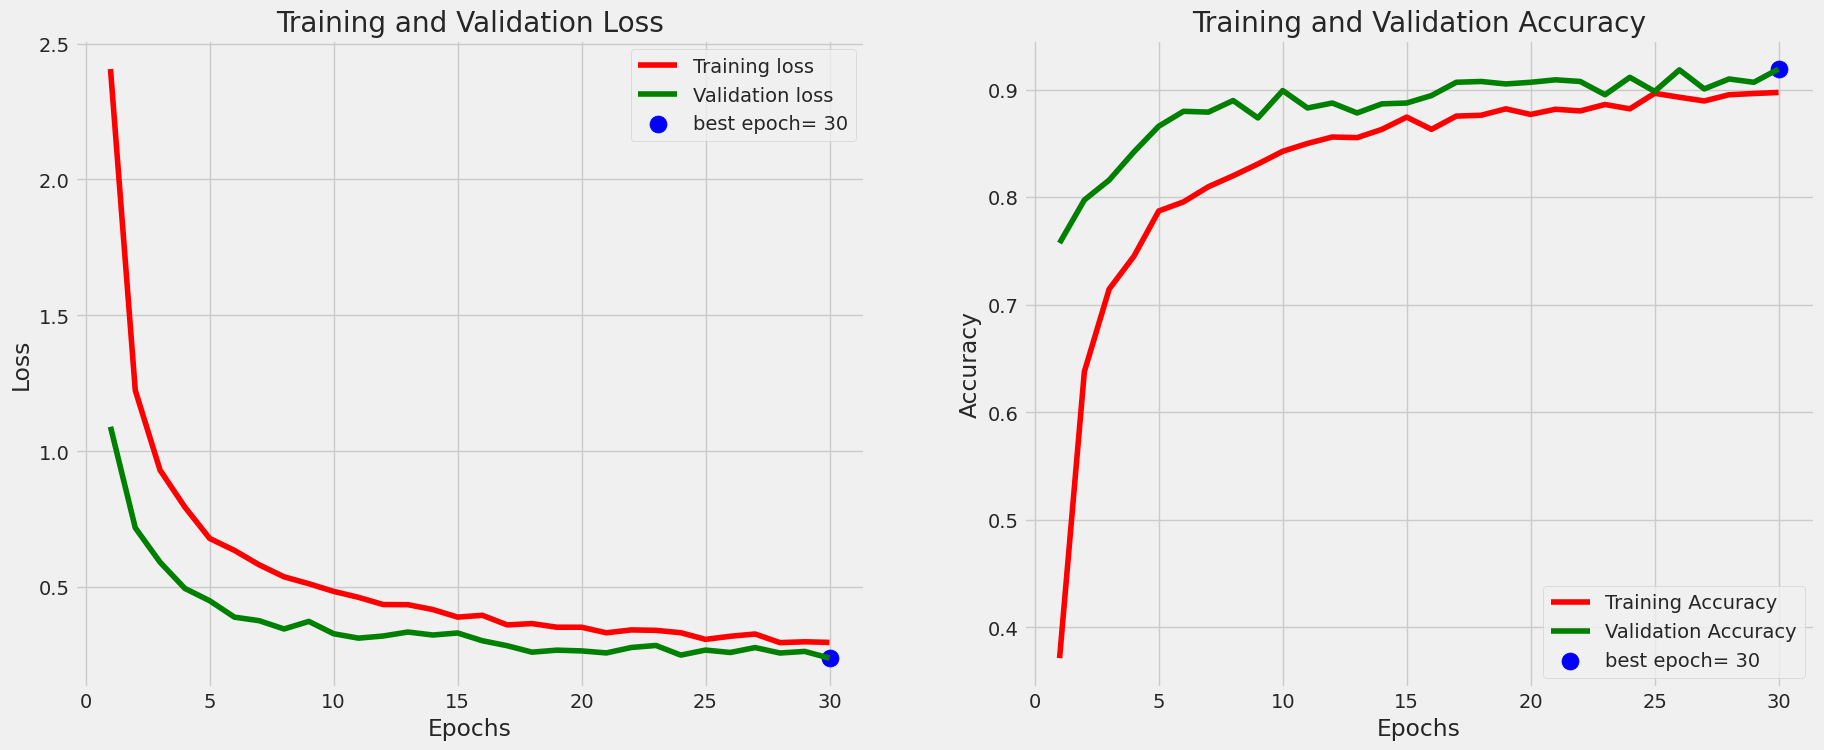

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

tr_plot(history,0)



In [ ]:
subject='model'
save_id= subject+ '.h5'
model_save_loc = save_id
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc )

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model was saved as  model.h5


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np

def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(300, 300))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the pixel values to be between 0 and 1
    return img_array

def classify_image(model, image_path, class_labels):
    img_array = load_and_preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_labels[predicted_class_index]
    confidence = predictions[0][predicted_class_index]

    return predicted_class, confidence

if __name__ == "__main__":
    # Load the saved model
    model_path = "model.h5"
    loaded_model = load_model(model_path)

    # Define your class labels
    class_labels = ['Apple Apple scab',
 'Apple Black rot',
 'Apple Cedar apple rust',
 'Apple healthy',
 'Bacterial leaf blight in rice leaf',
 'Blight in corn Leaf',
 'Blueberry healthy',
 'Brown spot in rice leaf',
 'Cercospora leaf spot',
 'Cherry (including sour) Powdery mildew',
 'Cherry (including_sour) healthy',
 'Common Rust in corn Leaf',
 'Corn (maize) healthy',
 'Garlic',
 'Grape Black rot',
 'Grape Esca Black Measles',
 'Grape Leaf blight Isariopsis Leaf Spot',
 'Grape healthy',
 'Gray Leaf Spot in corn Leaf',
 'Leaf smut in rice leaf',
 'Orange Haunglongbing Citrus greening',
 'Peach healthy',
 'Pepper bell Bacterial spot',
 'Pepper bell healthy',
 'Potato Early blight',
 'Potato Late blight',
 'Potato healthy',
 'Raspberry healthy',
 'Sogatella rice',
 'Soybean healthy',
 'Strawberry Leaf scorch',
 'Strawberry healthy',
 'Tomato Bacterial spot',
 'Tomato Early blight',
 'Tomato Late blight',
 'Tomato Leaf Mold',
 'Tomato Septoria leaf spot',
 'Tomato Spider mites Two spotted spider mite',
 'Tomato Target Spot',
 'Tomato Tomato mosaic virus',
 'Tomato healthy',
 'algal leaf in tea',
 'anthracnose in tea',
 'bird eye spot in tea',
 'brown blight in tea',
 'cabbage looper',
 'corn crop',
 'ginger',
 'healthy tea leaf',
 'lemon canker',
 'onion',
 'potassium deficiency in plant',
 'potato crop',
 'potato hollow heart',
 'red leaf spot in tea',
 'tomato canker'] # Replace with your actual class labels

    # Provide the path to the image you want to classify
    image_path = r"/content/Image Data base/Image Data base/Grape Black rot/Grape_Black_rot1308.jpg"

    # Perform image classification
    predicted_class, confidence = classify_image(loaded_model, image_path, class_labels)

    # Print the results
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence}")


1/1 [==============================] - 5s 5s/step
Predicted Class: Grape Black rot
Confidence: 0.9760767817497253


In [ ]:
model_path ='/content/model.h5'
model = tf.keras.models.load_model(model_path)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tf_lite_Optimize_DEFAULT_model = converter.convert()
print("Optimize.DEFAULT Quantization:- ",len(tf_lite_Optimize_DEFAULT_model))

Optimize.DEFAULT Quantization:-  22312336


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.target_spec.supported_types = [tf.float16]
OPTIMIZE_FOR_SIZE_model = converter.convert()
print("OPTIMIZE_FOR_SIZE Quantization [tf.float16]:- ",len(OPTIMIZE_FOR_SIZE_model))

OPTIMIZE_FOR_SIZE Quantization [tf.float16]:-  22312336


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
converter.target_spec.supported_types = [tf.float16]
OPTIMIZE_FOR_LATENCY_model = converter.convert()
print("OPTIMIZE_FOR_LATENCY Quantization:- ",len(OPTIMIZE_FOR_LATENCY_model))

OPTIMIZE_FOR_LATENCY Quantization:-  22312336


In [ ]:
with open("OPTIMIZE_FOR_SIZE_model.tflite", "wb") as f:
    f.write(OPTIMIZE_FOR_SIZE_model)

# save the DEFAULT Quantization model in HDF5 format
with open("tf_lite_Optimize_DEFAULT_model.tflite", "wb") as f:
    f.write(tf_lite_Optimize_DEFAULT_model)

# save the OPTIMIZE_FOR_LATENCY_model in HDF5 format
with open("OPTIMIZE_FOR_LATENCY_model.tflite", "wb") as f:
    f.write(OPTIMIZE_FOR_LATENCY_model)

In [ ]:
from PIL import Image

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def classify_image_tflite(interpreter, image_path, class_labels):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    img_array = load_and_preprocess_image(image_path, target_size=(input_details[0]['shape'][1], input_details[0]['shape'][2]))

    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()

    predictions = interpreter.get_tensor(output_details[0]['index'])
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_labels[predicted_class_index]
    confidence = predictions[0][predicted_class_index]

    return predicted_class, confidence

if __name__ == "__main__":
    # Load the TFLite model
    model_path_tflite = "/content/OPTIMIZE_FOR_SIZE_model.tflite"
    interpreter = tf.lite.Interpreter(model_path=model_path_tflite)
    interpreter.allocate_tensors()

    # Define your class labels
    class_labels = ['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']  # Replace with your actual class labels

    # Provide the path to the image you want to classify
    image_path = "/content/Image Data base/Image Data base/Cherry (including sour) Powdery mildew/Cherry_(including_sour)_Powdery_mildew109.jpg"

    # Perform image classification using TFLite model
    predicted_class, confidence = classify_image_tflite(interpreter, image_path, class_labels)

    # Print the results
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {str(str(100*(confidence)))}")

Predicted Class: Tomato_Septoria_leaf_spot
Confidence: 45.96811234951019
